In [1]:
from matplotlib import pyplot as plt
import numpy as np
import importlib

In [2]:
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

In [3]:
params_model = {
    "R" : 1.0,
    "Rz" : 0.5,
    "Bz" : 1.0,
    "eccentricity": 0.01,
    "sigma":0.1,
    "epsilon":1.0
}
params_init = {
    "energy": 1.0,
    "sigma_grid":0.2,
    "position_random_shift_percentage": 0.0/100,
    "planar": False,
    "zero_momentum": True
}
params_simulation = {}

## test initialisation

In [4]:
sim = SimulatorMagnetic(**params_model)
r_init = sim.init_positions_closepack(**params_init)

In [5]:
sim.L_given_E_constraint(1)

(933.572086695684, 516.129453913998)

In [6]:
sim.init_velocities(1, 300);

In [7]:
sim.angular_momentum(sim.r_init, sim.v_init)[-1].sum()

299.9999999999999

In [8]:
sim.total_energy(sim.r_init, sim.v_init).sum()

1053.0

In [9]:
sim.particle_number()

1053

## Simulate

In [16]:
params_model = {
    "R" : 1.0,
    "Rz" : 0.25,
    "Bz" : 1.0,
    "eccentricity": 0.01,
    "sigma":0.7,
    "epsilon":1.0
}
params_init = {
    "energy": 1.0,
    "sigma_grid":0.75,
    "position_random_shift_percentage": 0.0/100,
    "planar": False,
    "zero_momentum": True,
}
params_simulation = {}

In [20]:
sim = SimulatorMagnetic(**params_model)
sim.init_positions_closepack(**params_init)

params_init["angular_momentum"] = sim.L_given_E_constraint(params_init["energy"])[0]*0
sim.init_velocities(**params_init)

sim.particle_number()

13

In [21]:
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="EULER"))
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="RK"))
history = sim.to_array(sim.simulate(3, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [01:00<00:00, 4935.26it/s]


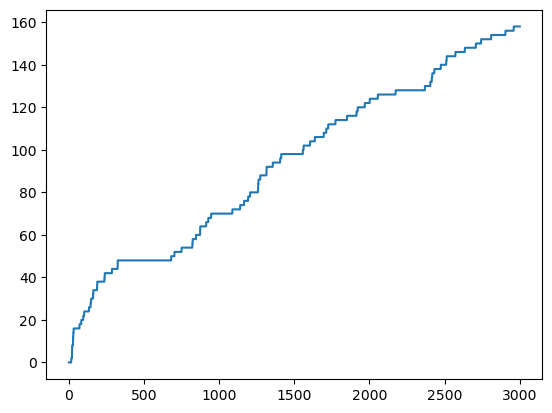

In [22]:
plt.plot(history["collisions"])

In [13]:
sim_id = sim.push_db(); sim_id

10

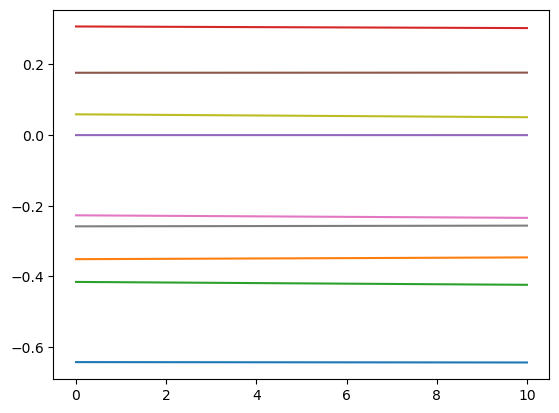

In [14]:
plt.plot(history["L"][:,2,:]);

Text(0.5, 1.0, 'Z Angular Momentum')

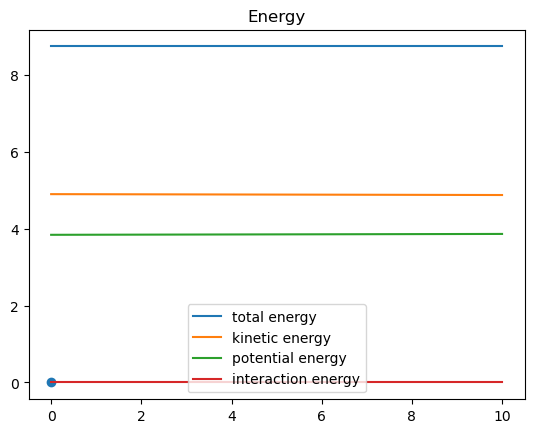

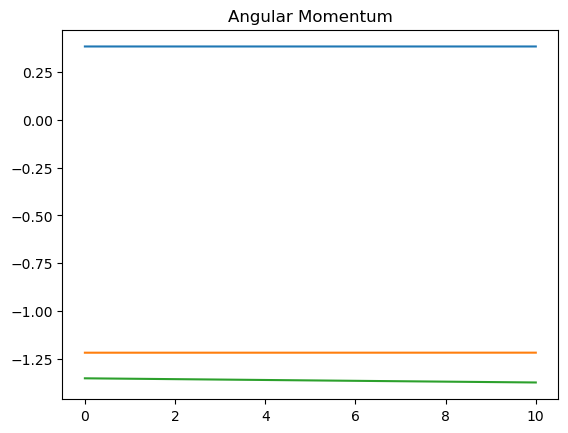

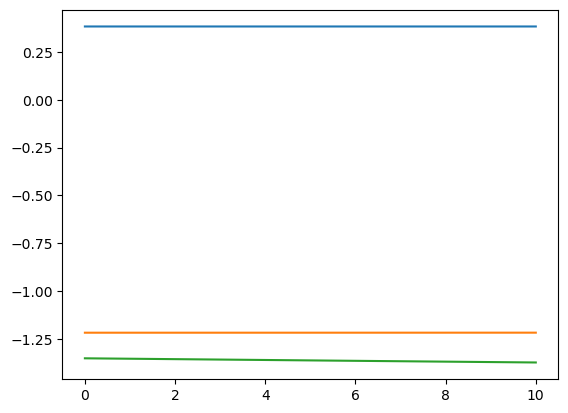

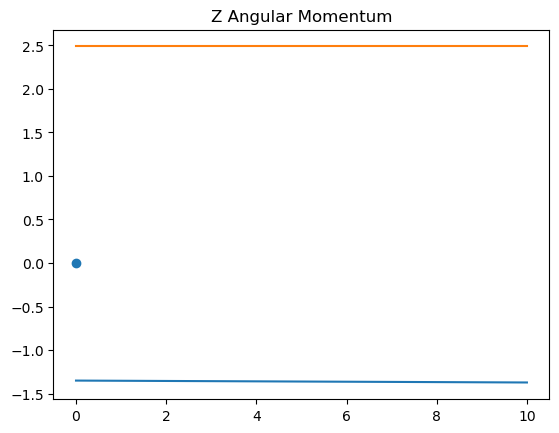

In [15]:
plt.figure()
plt.plot(np.sum(history["KE"] + history["PE"] + 0.5*history["IE"], axis=1), label="total energy")
plt.plot(np.sum(history["KE"], axis=1), label="kinetic energy")
plt.plot(np.sum(history["PE"], axis=1), label="potential energy")
plt.plot(0.5 * np.sum(history["IE"], axis=1), label="interaction energy")
plt.scatter(0,0)
plt.legend()
plt.title("Energy")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))
plt.title("Angular Momentum")

plt.figure()
plt.plot(np.sum(history["L"], axis=2))

plt.figure()
plt.plot(np.sum(history["L"][:,2], axis=1))
plt.plot(np.sum(history["L"][:,2] + history["BInertia"], axis=1))
plt.scatter(0,0)
plt.title("Z Angular Momentum")


IndexError: index 20 is out of bounds for axis 2 with size 9

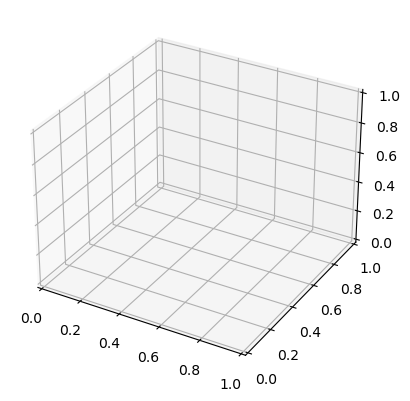

In [16]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
pi = 20
rs = history["rs"]
ax.plot(rs[:,0,pi], rs[:,1,pi], rs[:,2,pi])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [17]:
import datetime
import time

In [18]:
sim = SimulatorMagnetic(**params_model)
init = sim.init_positions_velocities(**params_init)
history = sim.to_array(sim.simulate(0.03, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

sim1 = SimulatorMagnetic(**params_model)
sim1.r_init, sim1.v_init = init
history1 = sim.to_array(sim1.simulate(0.01, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))
# history11 = sim.to_array(sim1.simulate(0.02, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))
id = sim1.push_db()

sim2 = SimulatorMagnetic()
sim2.load(id=id)
history2 = sim2.to_array(sim2.simulate(0.02, dt=1e-5, record_interval=1e-3, algorithm="VERLET"))

np.allclose(history2["rs"], history["rs"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3501.22it/s]


True

In [19]:
sim = SimulatorMagnetic(**params_model)
init = sim.init_positions_velocities(**params_init)

In [31]:
print(sim.angular_momentum(sim.r_init, sim.v_init)[2].sum())
sim.rotational_push(0.5)
print(sim.angular_momentum(sim.r_init, sim.v_init)[2].sum())


-1.0235617551807161
4.641855230012989


In [32]:
from multiprocessing import Pool, cpu_count

In [33]:
pool = Pool(cpu_count())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 7571.47it/s]


In [34]:
params_simulation = {
    "iteration_time" : 1,
    "dt" : 0.0005, 
    "record_interval" : 0.01, 
    "algorithm" : "EULER"
}

In [35]:
results = []
for i in range(3):
    sim = SimulatorMagnetic(name = "A", **params_model)
    init = sim.init_positions_velocities(**params_init)
    
    sim1 = SimulatorMagnetic(name = "A", **params_model)
    sim1.r_init, sim1.v_init = init

    results.append(pool.apply_async(sim.simulate_async, kwds=params_simulation))
    results.append(pool.apply_async(sim1.simulate_async, kwds=params_simulation))


In [36]:
np.array(sorted([x.get() for x in results])).shape

(6,)